In [1]:
from typing import List, Any, Dict, Tuple, Set
from operator import itemgetter
from itertools import combinations, starmap


import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

from conversant.conversation import Conversation
from conversant.interactions import InteractionsGraph
from conversant.conversation.parse import DataFrameConversationReader
from conversant.interactions.reply_interactions_parser import get_reply_interactions_parser
from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [2]:
data_path = "/home/dev/data/stance/IAC/alternative/convinceme/post.txt"
# data_path = "/home/dev/data/stance/IAC/alternative/createdebate_released/post.txt"
header = ["discussion_id", "post_id", "author_id", "creation_date", "parent_post_id",
          "parent_missing", "text_id", "points", "discussion_stance_id", "is_rebuttal"]

df = pd.read_csv(data_path, sep='\t', names=header, na_values="\\N")
df

,discussion_id,post_id,author_id,creation_date,parent_post_id,parent_missing,text_id,points,discussion_stance_id,is_rebuttal
0,1,1,10,2007-01-02 00:00:00,NaN,0,1,58,1,1
1,1,2,12,2007-01-04 00:00:00,NaN,0,2,59,1,1
2,1,3,1,2007-02-01 00:00:00,NaN,0,3,1,0,1
3,1,4,1,2007-02-01 00:00:00,2.0,0,4,0,0,1
4,1,5,1,2007-02-01 00:00:00,6.0,0,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...
65363,5413,1,5782,2012-07-28 00:00:00,NaN,0,65364,1,1,1
65364,5413,2,3747,2012-08-05 00:00:00,NaN,0,65365,1,1,1
65365,5413,3,5783,2012-08-06 00:00:00,NaN,0,65366,0,0,1
65366,5413,4,5649,2012-08-16 00:00:00,NaN,0,65367,1,1,1


In [3]:
len(df["discussion_id"].unique())

5413

In [4]:
df["parent_post_id"].isna().sum()

32220

In [5]:
pasre_strategy = {
    "node_id": "post_id",
    "author": "author_id",
    "timestamp": "creation_date",
    "parent_id": "parent_post_id"
    }
parser = DataFrameConversationReader(pasre_strategy)

In [6]:
gb = df.groupby("discussion_id")

In [7]:
it = iter(gb)

In [8]:
name, ddf = next(it)
print(it)
conv = parser.parse(ddf)
conv

<generator object BaseGrouper.get_iterator at 0x7f7e061a4890>


10 - 1

In [9]:
convs = list(map(parser.parse, map(itemgetter(1), gb)))

In [10]:
sizes = [c.size for c in convs]
print(len(sizes))
print(np.mean(sizes))
print(np.median(sizes))

5413
2.964160354701644
1.0


In [11]:
filtered_sizes = [s for s in sizes if s >= 5]
print(len(filtered_sizes))
print(np.mean(filtered_sizes))
print(np.median(filtered_sizes))



892
10.042600896860986
7.0


In [12]:
large_convs = [c for c in convs if c.size >=10]

In [13]:
def get_majority_vote(labels: List[int]) -> int:
    return int(np.mean(labels) >= 0.5)

def get_author_labels(conv: Conversation) -> Dict[Any, int]:
    authors_post_labels = {}
    for depth, node in conv.iter_conversation():
        data = node.data
        author = node.author
        author_labels = authors_post_labels.setdefault(author, [])
        author_labels.append(data["discussion_stance_id"])

    authors_labels = {a: get_majority_vote(labels) for a, labels in authors_post_labels.items()}
    return authors_labels

def get_maxcut_results(graph: InteractionsGraph, op: Any) -> MaxcutStanceClassifier:
    maxcut = MaxcutStanceClassifier()
    maxcut.set_input(graph.graph)
    maxcut.classify_stance(op)
    # maxcut.draw()
    return maxcut

def align_gs_with_predictions(maxcut: MaxcutStanceClassifier, authors_labels: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    support_label = authors_labels[op]
    opposer_label = 1 - support_label
    supporters = maxcut.get_supporters()
    opposers = maxcut.get_complement()

    y_true, y_pred = [], []
    for supporter in supporters:
        true_label = authors_labels[supporter]
        y_true.append(true_label)
        y_pred.append(support_label)

    for opposer in opposers:
        true_label = authors_labels[opposer]
        y_true.append(true_label)
        y_pred.append(opposer_label)

    return y_true, y_pred

def align_posts_gs_with_predictions(conv: Conversation, authors_labels: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    for (_, node) in conv.iter_conversation():
        y_true.append(node.data["discussion_stance_id"])
        pred = authors_labels[node.author]
        y_pred.append(pred)

    return y_true, y_pred

In [14]:
reply_interactions_parser = get_reply_interactions_parser()
y_true, y_pred = [], []
posts_true, posts_pred = [], []
filtered_convs = []
empty_core = []
results: List[Tuple[np.ndarray, Set[int], Set[int]]] = []

for conv in convs:
    interaction_graph = reply_interactions_parser.parse(conv)
    op = conv.root.author
    interaction_graph.graph.add_edge(op, -1, replies=1)
    interaction_graph.graph.add_edge(op, -2, replies=1)
    interaction_graph.graph.add_edge(-1, -2, replies=1)

    interaction_graph.set_interaction_weights(lambda x: x['replies'])
    if len(list(interaction_graph.graph.neighbors(op))) <= 1:
        op_not_connected.append(conv)
        continue

    kcore = interaction_graph.get_core_interactions()
    if kcore.graph.order() == 0:
        empty_core.append(conv)
        continue

    if op not in kcore.graph.nodes:
        print(kcore.graph.nodes)
        op_not_in_core.append(conv)
        continue

    kcore.graph.remove_nodes_from([-1, -2])
    kcore = kcore.get_op_connected_components()
    maxcut = get_maxcut_results(kcore, op)
    authors_labels = get_author_labels(conv)
    true, preds = align_gs_with_predictions(maxcut, authors_labels)
    y_true.extend(true)
    y_pred.extend(preds)

    true, preds = align_posts_gs_with_predictions(conv, authors_labels)
    posts_true.extend(true)
    posts_pred.extend(preds)
    filtered_convs.append(conv)
    results.append((maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()))


print(f"total number of conversations: {len(convs)}")
print(f"number of conversations with empty core: {len(empty_core)}")
print(f"number of conversations in eval: {len(filtered_convs)}")
print(f"number of authors in eval: {len(y_true)}")
print(f"number of posts in eval: {len(posts_true)}")

total number of conversations: 5413
number of conversations with empty core: 5179
number of conversations in eval: 234
number of authors in eval: 929
number of posts in eval: 3476


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       426
           1       0.89      0.83      0.86       503

    accuracy                           0.85       929
   macro avg       0.85      0.85      0.85       929
weighted avg       0.85      0.85      0.85       929



In [16]:
print(classification_report(posts_true, posts_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1677
           1       0.91      0.96      0.93      1799

    accuracy                           0.93      3476
   macro avg       0.93      0.93      0.93      3476
weighted avg       0.93      0.93      0.93      3476



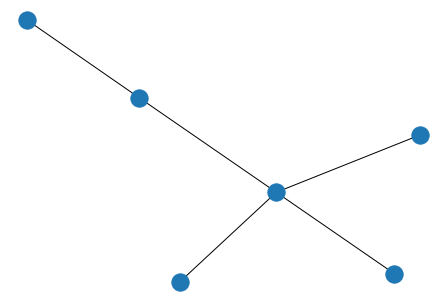

In [25]:
interaction_graph = reply_interactions_parser.parse(convs[4])
layout = nx.spring_layout(interaction_graph.graph)
nx.draw(interaction_graph.graph, layout)

3


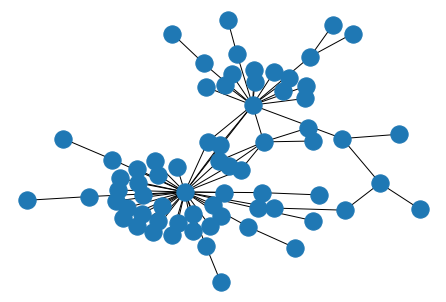

In [45]:
def get_graphs():
    for j, conv in enumerate(large_convs):
        interaction_graph = reply_interactions_parser.parse(conv)
        if interaction_graph.graph.order() > 10:
            kcore = interaction_graph.get_core_interactions()
            if kcore.graph.order() > 5:
                print(j)
                yield(interaction_graph)

graphs = get_graphs()

i = next(graphs)
layout = nx.spring_layout(i.graph)
nx.draw(i.graph, layout)

92
115


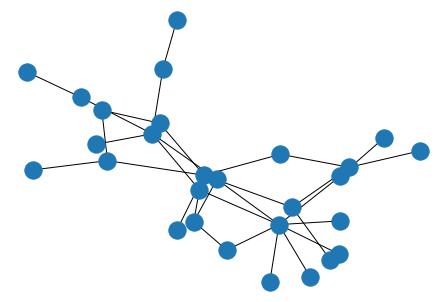

In [47]:
i = next(graphs)
layout = nx.spring_layout(i.graph)
nx.draw(i.graph, layout)

In [ ]:
i = next(graphs)
layout = nx.spring_layout(i.graph)
nx.draw(i.graph, layout)

139


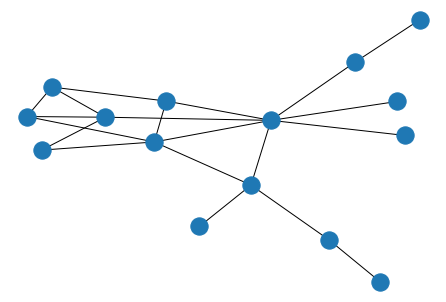

In [48]:
i = next(graphs)
layout = nx.spring_layout(i.graph)
nx.draw(i.graph, layout)

In [36]:
print(large_convs[0])

16 - 1
├── 16 - 9
│   └── 987 - 308
├── 987 - 307
├── 987 - 309
├── 987 - 310
├── 909 - 400
├── 891 - 411
├── 1039 - 448
│   └── 980 - 450
└── 902 - 491
    └── 989 - 512


In [18]:
supporters_avg_angles = []
opposers_avg_angles = []
mean_cross_angle = []

for i in range(len(results)):
    r = results[i]
    supporters_distances = list(starmap(lambda i, j: cosine(r[0][i], r[0][j]), combinations(r[1], 2)))
    opposers_distances = list(starmap(lambda i, j: cosine(r[0][i], r[0][j]), combinations(r[2], 2)))
    supporters_avg_angle = np.mean(supporters_distances)
    opposers_avg_angle = np.mean(opposers_distances)

    supporters_avg_angles.append(supporters_avg_angle)
    opposers_avg_angles.append(opposers_avg_angle)

    supporters_mean_embedding = np.mean([np.array(r[0][i]) for i in r[1]], axis=0)[0]
    opposers_mean_embedding = np.mean([np.array(r[0][i]) for i in r[2]], axis=0)[0]
    cross_angle = cosine(supporters_mean_embedding, opposers_mean_embedding)
    mean_cross_angle.append(cross_angle)

print(f"support {len(results)}")
print(f"support cosine {len(results)}")
print(f"support {len(results)}")
print(f"support {len(results)}")
len(results), np.nanmean(supporters_avg_angles), np.nanmean(opposers_avg_angles), np.mean(mean_cross_angle)

support 234
support cosine 234
support 234
support 234


/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(234, 0.21138606809385396, 0.49938015526250007, 1.9696798334454442)

In [87]:
max_i = 0
max_shape = 0
sizes = [(i, len(r[0])) for i, r in enumerate(results)]
sorted_sized = sorted(sizes, key=itemgetter(1), reverse=True)
sorted_sized[:20]



[(0, 12),
 (137, 9),
 (175, 9),
 (77, 8),
 (119, 8),
 (1, 7),
 (8, 7),
 (26, 7),
 (37, 7),
 (59, 7),
 (75, 7),
 (93, 7),
 (135, 7),
 (149, 7),
 (192, 7),
 (12, 6),
 (30, 6),
 (76, 6),
 (86, 6),
 (116, 6)]

In [88]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
r = results[0]
X = np.vstack([np.array(x) for x in r[0].values()])
X_pca = PCA(n_components=2).fit_transform(X)
X_tsne = TSNE(n_components=2).fit_transform(X)

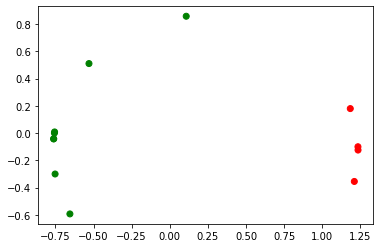

In [50]:
nodes = r[0].keys()
colors = ['r' if i in r[1] else 'g' for i in nodes]
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors)
#

In [95]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors)


In [22]:
df.is_rebuttal.describe()

count    65368.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: is_rebuttal, dtype: float64